## Training to velocities, 1st derivatives and laplacians

In [12]:
from jax_cfd.ml.diego_cnn_bcs import *

#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
from jax_cfd.ml.diego_preprocessing import *
from jax_cfd.ml.diego_train_functions import *
from jax_cfd.ml import nonlinearities

from jax_cfd.ml.newSaveObject import *
from jax_cfd.ml.diego_towers import *

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [19]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

In [20]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 64, 256, 2)


In [21]:
%time high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

CPU times: user 66.9 ms, sys: 36.1 ms, total: 103 ms
Wall time: 103 ms


## Defining what we are training towards

In [22]:
which_outputs = {
        "u" : False,
        "du" : False,
        "lapu" : True,
        
        "v" : False,
        "dv" : False,
        "lapv" : True
    }

conditions = [
#             [0,0],#u
#             [0,0],#dudx
#             [0,0],#dudy
            [0,0],#lapu

#             [0,0],#v
#             [0,0],#dvdx
#             [0,0],#dvdy
            [0,0]#lapv
        ]

In [23]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)

print("\nCreate Y dataset: ")
%time Y_dataset = createDatasetDerivatives(high_def_norm,sampling,factor,which_outputs)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

# NOTE: padding conditions can be specified via the "conditions" input to the padYDataset function below
# the padXDataset only pads u and v for channel flow conditions, so hard coded for impermeability and no-slip conditions (0,0)
print("\nPadding all datasets: ")
padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
%time X_train = padXDataset(X_train,padding)
%time Y_train = padYDataset(Y_train,padding,conditions)

%time X_test = padXDataset(X_test,padding)
%time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 19.8 s, sys: 21.1 ms, total: 19.8 s
Wall time: 19.9 s

Create Y dataset: 
CPU times: user 1.39 s, sys: 13.7 ms, total: 1.41 s
Wall time: 1.41 s

Padding all datasets: 
CPU times: user 14 s, sys: 8.31 ms, total: 14 s
Wall time: 14.1 s
CPU times: user 13.9 s, sys: 11.8 ms, total: 13.9 s
Wall time: 13.9 s
CPU times: user 3.46 s, sys: 5.44 ms, total: 3.47 s
Wall time: 3.49 s
CPU times: user 3.47 s, sys: 2.12 ms, total: 3.47 s
Wall time: 3.48 s

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 2)
(173, 18, 66, 2)
(173, 18, 66, 2)


## Defining model shape

In [24]:
def ConvNet(x):
    cnn = CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 16,
    "hidden_layers" : 3,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [25]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [ ]:
instance = MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs = 50,
                      printEvery=5,
                      learning_rates=staggeredLearningRate((120,0.01),(70,0.001)),
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 2)
(173, 18, 66, 2)
(173, 18, 66, 2)



Start time: 1:02:37
Epoch 5/50
	mse : 0.020954		val mse : 0.020839	Estimated end time: 1:14:40


Epoch 10/50
	mse : 0.013094		val mse : 0.013023	Estimated end time: 1:15:49


Epoch 15/50
	mse : 0.009312		val mse : 0.009259	Estimated end time: 1:16:13


Epoch 20/50
	mse : 0.007275		val mse : 0.007230	Estimated end time: 1:16:26


Epoch 25/50
	mse : 0.006098		val mse : 0.006057	Estimated end time: 1:16:35


Epoch 30/50
	mse : 0.005380		val mse : 0.005341	Estimated end time: 1:16:41


Epoch 35/50
	mse : 0.004921		val mse : 0.004885	Estimated end time: 1:16:44


Epoch 40/50
	mse : 0.004616		val mse : 0.004580	Estimated end time: 1:16:47




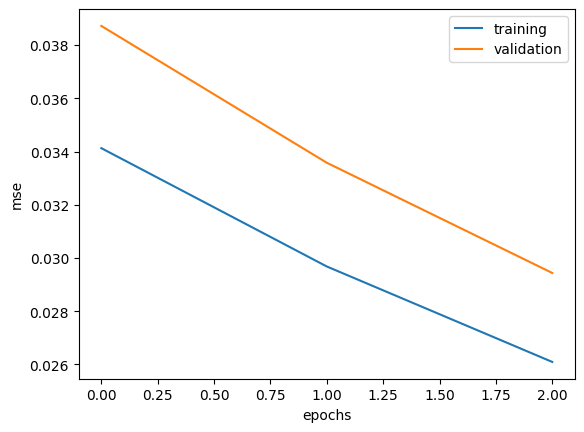

In [14]:
step = 1

plt.plot(instance.losses[::step], label="training")
plt.plot(instance.val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

In [ ]:
#copy these and add them to the saved model I just trained

In [16]:
description = ""

In [17]:
toSave = newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [8]:
save_path = "./../models/correctors/laplacian_correctors/MODEL_NAME.pickle"

In [17]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [18]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [19]:
loaded.description

'57 min CPU time, learning_rates = ((120,0.01),(30,0.001)), 150 epochs'

## Evaluating the model 

In [22]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [23]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

NameError: name 'X_test' is not defined

In [24]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [25]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [26]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(npLaplacian(X_test[j]))

NameError: name 'X_test' is not defined

In [107]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [106]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||predictions||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(predictions))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||predictions||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(predictions))))

Test error for NN
	Error : 0.042082
	Error/mean(||predictions||) : 1.213610

Error if no NN used
	Error : 0.237708
	Error/mean(||predictions||) : 6.855296
